## Exploration and clustering of the neighborhoods in Toronto.

#### Fistly, we will import everything we might need

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt  
from matplotlib import style 

import json

from geopy.geocoders import Nominatim
import geocoder

import requests
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Libraries imported.


#### Then we should fetch data from <a link='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'> Wikipedia</a> with PostalCode, Borough, and Neighborhood

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
lst = pd.read_html(url)

In [3]:
neighborhoods=pd.DataFrame(lst[0])

The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood

In [4]:
neighborhoods.head()

Postal Code           Borough               Neighborhood
0         M1A      Not assigned               Not assigned
1         M2A      Not assigned               Not assigned
2         M3A        North York                  Parkwoods
3         M4A        North York           Victoria Village
4         M5A  Downtown Toronto  Regent Park, Harbourfront

Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.

In [5]:
neighborhoods = neighborhoods.drop(neighborhoods[neighborhoods['Borough']=='Not assigned'].index)

In [6]:
neighborhoods.head()

Postal Code           Borough                                 Neighborhood
2         M3A        North York                                    Parkwoods
3         M4A        North York                             Victoria Village
4         M5A  Downtown Toronto                    Regent Park, Harbourfront
5         M6A        North York             Lawrence Manor, Lawrence Heights
6         M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government

More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma.

In [7]:
neighborhoods = neighborhoods.groupby(['Postal Code','Borough']).agg({'Neighborhood': list})
neighborhoods = neighborhoods.reset_index()
neighborhoods['Neighborhood'] = neighborhoods['Neighborhood'].apply(lambda x: ','.join(x))
#neighborhoods['Borough'] = neighborhoods['Borough'].apply(lambda x: ','.join(x))                                     

In [8]:
neighborhoods.head()

Postal Code      Borough                            Neighborhood
0         M1B  Scarborough                          Malvern, Rouge
1         M1C  Scarborough  Rouge Hill, Port Union, Highland Creek
2         M1E  Scarborough       Guildwood, Morningside, West Hill
3         M1G  Scarborough                                  Woburn
4         M1H  Scarborough                               Cedarbrae

And we should check if there are any borough that are not assigned.

In [9]:
neighborhoods.loc[neighborhoods['Borough'].isin(["Not assigned"])]

Empty DataFrame
Columns: [Postal Code, Borough, Neighborhood]
Index: []

Let's check dimentions of our dataframe

### Next we should get geodata of neighborhoods above

Let's upload csv data with geografical coordinates of neighborhoods of Toronto assiciated with postal codes.

In [10]:
coords = pd.read_csv('Geospatial_Coordinates.csv')

In [11]:
coords.head()

Postal Code   Latitude  Longitude
0         M1B  43.806686 -79.194353
1         M1C  43.784535 -79.160497
2         M1E  43.763573 -79.188711
3         M1G  43.770992 -79.216917
4         M1H  43.773136 -79.239476

We will megre neighborhoods data (neighborhoods dataframe) and coordinates of neighborhoods (coords dataframe).

In [12]:
df = pd.merge(neighborhoods, coords, on='Postal Code')

In [13]:
df.head()

Postal Code      Borough                            Neighborhood   Latitude  \
0         M1B  Scarborough                          Malvern, Rouge  43.806686   
1         M1C  Scarborough  Rouge Hill, Port Union, Highland Creek  43.784535   
2         M1E  Scarborough       Guildwood, Morningside, West Hill  43.763573   
3         M1G  Scarborough                                  Woburn  43.770992   
4         M1H  Scarborough                               Cedarbrae  43.773136   

   Longitude  
0 -79.194353  
1 -79.160497  
2 -79.188711  
3 -79.216917  
4 -79.239476

Let's check how many neighborhoods are in each borough

In [14]:
df.groupby('Borough').count()['Neighborhood']

Borough
Central Toronto      9
Downtown Toronto    19
East Toronto         5
East York            5
Etobicoke           12
Mississauga          1
North York          24
Scarborough         17
West Toronto         6
York                 5
Name: Neighborhood, dtype: int64

Text(0, 0.5, 'No of neighborhood')

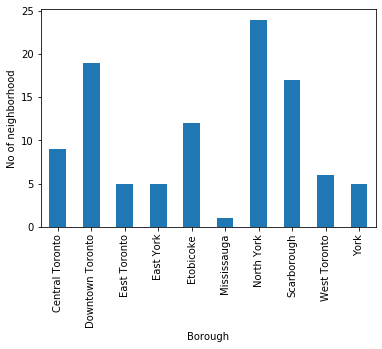

In [15]:
df.groupby('Borough').count()['Neighborhood'].plot(kind='bar')
plt.ylabel('No of neighborhood')

The most dense boroughs are Notrh York (24 areas), Downtown Toronto (19 areas) and Scarborough (17 areas).

We have got data with PC, Borough, Neighborhood, and coordinates.
Now will narrow this dataset to boroughs that contain 'Toronto' in their name

In [16]:
#df = df[df['Borough'].str.contains('Toronto')]
df = df.reset_index()
df.drop('index',axis=1,inplace=True)
df.head()

Postal Code      Borough                            Neighborhood   Latitude  \
0         M1B  Scarborough                          Malvern, Rouge  43.806686   
1         M1C  Scarborough  Rouge Hill, Port Union, Highland Creek  43.784535   
2         M1E  Scarborough       Guildwood, Morningside, West Hill  43.763573   
3         M1G  Scarborough                                  Woburn  43.770992   
4         M1H  Scarborough                               Cedarbrae  43.773136   

   Longitude  
0 -79.194353  
1 -79.160497  
2 -79.188711  
3 -79.216917  
4 -79.239476

### Now we will start out exploration of Toronto, Canada

Firslty, let's get Toronto coordinates and make a map of the city with all neightborhoods we got above

In [18]:
pip install geopy[aiohttp]

Note: you may need to restart the kernel to use updated packages.


We have used Async mode of GeoPy because regular one appears to be picky bastard that does not want to work properly on my machine.

In [19]:
from geopy.adapters import AioHTTPAdapter
from geopy.geocoders import Nominatim

async with Nominatim(
    user_agent="canada_explorer",
    adapter_factory=AioHTTPAdapter,
) as geolocator:
    location = await geolocator.geocode("Toronto, Canada")
print('The geograpical coordinate of Toronto are {}, {}.'.format(location.latitude, location.longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


We have got coordinates of Toronto to make a map

In [20]:
map_toronto = folium.Map(location=[location.latitude, location.longitude], zoom_start=12, tiles="CartoDB dark_matter")

boroughs = df['Borough'].unique().tolist()

borough_color = {}
for borough in boroughs:
    borough_color[borough]= '#%02X%02X%02X' % tuple(np.random.choice(range(256), size=3))

for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{} - {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color=borough_color[borough],
        fill_color=borough_color[borough],
        fill_opacity=1,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Now we should get profiles of neighborhoods based on most common venues in them. To get this information we will use Foursquare API

In [21]:
CLIENT_ID = 'ZZS0AL4NN4QA4KHMVFRTI4VNSRPG0AQKBK5Q5UTF4YHEYUCO'
CLIENT_SECRET = 'FA2HSAEYTUJ2NWTOWIRCXSMVWZ4E2VBKZPOBBTVE4QAAHQQT'
VERSION = '20180605'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ZZS0AL4NN4QA4KHMVFRTI4VNSRPG0AQKBK5Q5UTF4YHEYUCO
CLIENT_SECRET:FA2HSAEYTUJ2NWTOWIRCXSMVWZ4E2VBKZPOBBTVE4QAAHQQT


Next we should define functions to get information about neighborhoods/venues from Foursquere

In [22]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [23]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000, LIMIT = 200):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [24]:
toronto_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto, Broadview North (Old East York)
The Danforth West, 

Let's look what we got

In [25]:
print(toronto_venues.shape)
toronto_venues.head()

(4907, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Malvern, Rouge              43.806686              -79.194353   
1  Malvern, Rouge              43.806686              -79.194353   
2  Malvern, Rouge              43.806686              -79.194353   
3  Malvern, Rouge              43.806686              -79.194353   
4  Malvern, Rouge              43.806686              -79.194353   

                 Venue  Venue Latitude  Venue Longitude  \
0   Images Salon & Spa       43.802283       -79.198565   
1             Harvey's       43.800020       -79.198307   
2  Staples Morningside       43.800285       -79.196607   
3              Wendy’s       43.807448       -79.199056   
4       RBC Royal Bank       43.798782       -79.197090   

                  Venue Category  
0                            Spa  
1                     Restaurant  
2  Paper / Office Supplies Store  
3           Fast Food Restaurant  
4                           Bank

In [26]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))
toronto_venues.groupby('Neighborhood').count()

There are 329 uniques categories.


Neighborhood Latitude  \
Neighborhood                                                             
Agincourt                                                           46   
Alderwood, Long Branch                                              24   
Bathurst Manor, Wilson Heights, Downsview North                     28   
Bayview Village                                                     17   
Bedford Park, Lawrence Manor East                                   41   
...                                                                ...   
Willowdale, Willowdale West                                         13   
Woburn                                                               8   
Woodbine Heights                                                    27   
York Mills West                                                     16   
York Mills, Silver Hills                                             4   

                                                 Neighborhood Longitude  \
Neighborhood                                                              
Agincourt                                                            46   
Alderwood, Long Branch                                               24   
Bathurst Manor, Wilson Heights, Downsview North                      28   
Bayview Village                                                      17   
Bedford Park, Lawrence Manor East                                    41   
...                                                                 ...   
Willowdale, Willowdale West                                          13   
Woburn                                                                8   
Woodbine Heights                                                     27   
York Mills West                                                      16   
York Mills, Silver Hills                                              4   

                                                 Venue  Venue Latitude  \
Neighborhood                                                             
Agincourt                                           46              46   
Alderwood, Long Branch                              24              24   
Bathurst Manor, Wilson Heights, Downsview North     28              28   
Bayview Village                                     17              17   
Bedford Park, Lawrence Manor East                   41              41   
...                                                ...             ...   
Willowdale, Willowdale West                         13              13   
Woburn                                               8               8   
Woodbine Heights                                    27              27   
York Mills West                                     16              16   
York Mills, Silver Hills                             4               4   

                                                 Venue Longitude  \
Neighborhood                                                       
Agincourt                                                     46   
Alderwood, Long Branch                                        24   
Bathurst Manor, Wilson Heights, Downsview North               28   
Bayview Village                                               17   
Bedford Park, Lawrence Manor East                             41   
...                                                          ...   
Willowdale, Willowdale West                                   13   
Woburn                                                         8   
Woodbine Heights                                              27   
York Mills West                                               16   
York Mills, Silver Hills                                       4   

                                                 Venue Category  
Neighborhood                                                     
Agincourt                                                    46  
Alderwood, Long Branch                                       24 

And let's have a look what venues are there

In [27]:
total_cloud = toronto_venues['Venue Category'].unique()
print("The Venue Categories are", toronto_venues['Venue Category'].unique())

The Venue Categories are ['Spa' 'Restaurant' 'Paper / Office Supplies Store' 'Fast Food Restaurant'
 'Bank' 'Caribbean Restaurant' 'Hobby Shop' 'Bus Station' 'Coffee Shop'
 'Trail' 'African Restaurant' 'Auto Workshop' 'Chinese Restaurant' 'Gym'
 'Supermarket' 'Bakery' 'Sandwich Place' 'Burger Joint' 'Breakfast Spot'
 'Italian Restaurant' 'Playground' 'Park' 'Fried Chicken Joint'
 'Liquor Store' 'Food & Drink Shop' 'Pizza Place' 'Smoothie Shop'
 'Beer Store' 'Pharmacy' 'Sports Bar' 'Discount Store' 'Greek Restaurant'
 'Grocery Store' 'Salon / Barbershop' 'Indian Restaurant'
 'Mobile Phone Shop' 'Hakka Restaurant' 'Thai Restaurant'
 'Athletics & Sports' 'Music Store' 'Gas Station' 'Yoga Studio'
 'Wings Joint' 'Bus Line' 'Sporting Goods Shop' 'Pet Store' 'Intersection'
 'Ice Cream Shop' 'Convenience Store' 'Japanese Restaurant'
 'Train Station' 'Bowling Alley' 'Department Store' 'Hockey Arena'
 'Light Rail Station' 'Rental Car Location' 'Asian Restaurant'
 'Mexican Restaurant' 'Pub' 'Metr

### Let visualize venues in Toronto with WordCloud

Firstly, we should install WordCloud package itself

In [29]:
 conda install -c conda-forge wordcloud

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


And define function to build WordCloud itself.

In [30]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud_big(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(24, 24))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=30)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
def show_wordcloud_small(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=50,
        max_font_size=40, 
        scale=3,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(24, 24))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=30)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

So let's try to build one

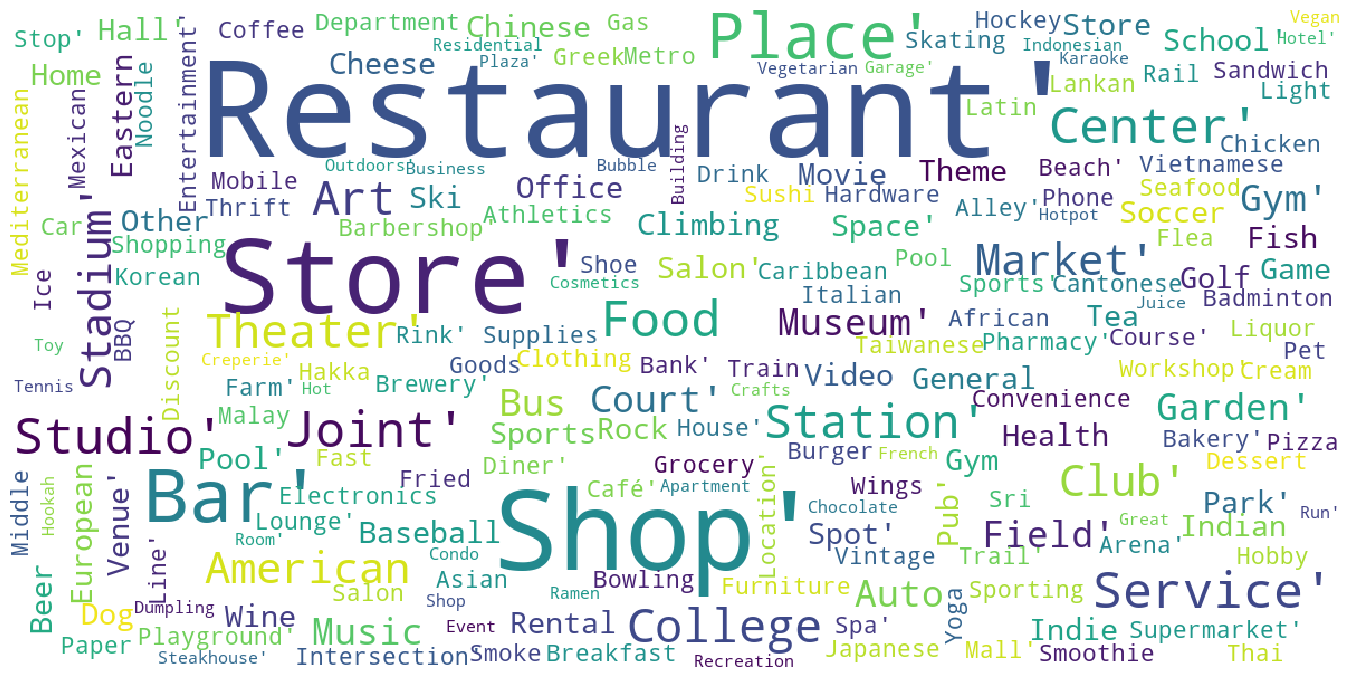

In [31]:
show_wordcloud_big(toronto_venues['Venue Category'].unique())

In [32]:
"Mexican Restaurant" in toronto_venues['Venue Category'].unique()

True

#### Let's analyze each neighborhood

In [33]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

Zoo  Accessories Store  Afghan Restaurant  African Restaurant  Airport  \
0    0                  0                  0                   0        0   
1    0                  0                  0                   0        0   
2    0                  0                  0                   0        0   
3    0                  0                  0                   0        0   
4    0                  0                  0                   0        0   

   American Restaurant  Amphitheater  Animal Shelter  Antique Shop  Aquarium  \
0                    0             0               0             0         0   
1                    0             0               0             0         0   
2                    0             0               0             0         0   
3                    0             0               0             0         0   
4                    0             0               0             0         0   

   ...  Video Game Store  Video Store  Vietnamese Restaurant  Warehouse Store  \
0  ...                 0            0                      0                0   
1  ...                 0            0                      0                0   
2  ...                 0            0                      0                0   
3  ...                 0            0                      0                0   
4  ...                 0            0                      0                0   

   Whisky Bar  Wine Bar  Wine Shop  Wings Joint  Women's Store  Yoga Studio  
0           0         0          0            0              0            0  
1           0         0          0            0              0            0  
2           0         0          0            0              0            0  
3           0         0          0            0              0            0  
4           0         0          0            0              0            0  

[5 rows x 329 columns]

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [34]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

Neighborhood  Zoo  Accessories Store  \
0                                        Agincourt  0.0                0.0   
1                           Alderwood, Long Branch  0.0                0.0   
2  Bathurst Manor, Wilson Heights, Downsview North  0.0                0.0   
3                                  Bayview Village  0.0                0.0   
4                Bedford Park, Lawrence Manor East  0.0                0.0   

   Afghan Restaurant  African Restaurant  Airport  American Restaurant  \
0                0.0                 0.0      0.0             0.021739   
1                0.0                 0.0      0.0             0.000000   
2                0.0                 0.0      0.0             0.000000   
3                0.0                 0.0      0.0             0.000000   
4                0.0                 0.0      0.0             0.024390   

   Amphitheater  Animal Shelter  Antique Shop  ...  Video Game Store  \
0           0.0             0.0           0.0  ...               0.0   
1           0.0             0.0           0.0  ...               0.0   
2           0.0             0.0           0.0  ...               0.0   
3           0.0             0.0           0.0  ...               0.0   
4           0.0             0.0           0.0  ...               0.0   

   Video Store  Vietnamese Restaurant  Warehouse Store  Whisky Bar  Wine Bar  \
0      0.00000               0.021739              0.0         0.0       0.0   
1      0.00000               0.000000              0.0         0.0       0.0   
2      0.00000               0.000000              0.0         0.0       0.0   
3      0.00000               0.000000              0.0         0.0       0.0   
4      0.02439               0.000000              0.0         0.0       0.0   

   Wine Shop  Wings Joint  Women's Store  Yoga Studio  
0        0.0      0.00000            0.0          0.0  
1        0.0      0.00000            0.0          0.0  
2        0.0      0.00000            0.0          0.0  
3        0.0      0.00000            0.0          0.0  
4        0.0      0.02439            0.0          0.0  

[5 rows x 329 columns]

In [35]:
ita = toronto_grouped[['Neighborhood','Mexican Restaurant']]
ita.sort_values(by=['Mexican Restaurant'], ascending=False)

Neighborhood  Mexican Restaurant
87  West Deane Park, Princess Gardens, Martin Grov...            0.066667
54       New Toronto, Mimico South, Humber Bay Shores            0.055556
10                                Caledonia-Fairbanks            0.050000
56                  North Toronto West, Lawrence Park            0.046512
11              Canada Post Gateway Processing Centre            0.036364
..                                                ...                 ...
39                                   Humberlea, Emery            0.000000
38                                      Humber Summit            0.000000
37                                  Hillcrest Village            0.000000
35  Harbourfront East, Union Station, Toronto Islands            0.000000
97                           York Mills, Silver Hills            0.000000

[98 rows x 2 columns]

Too explore our data let's get top 5 venues in each neighborhood

### Now we should start clustering Toronto

Now we should apply KMean algorithm to cluster out neighborhood.\
First of all, lets define most suitable k for our dataset using elbow method

In [36]:
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=15, random_state=8)
X = ita.drop(['Neighborhood'], axis=1)

In [37]:
kmeans.fit(X)
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [38]:
def get_inertia(n_clusters):
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=15, random_state=8)
    km.fit(X)
    return km.inertia_

In [39]:
scores = [get_inertia(x) for x in range(2, 14)]

Text(0, 0.5, 'Error')

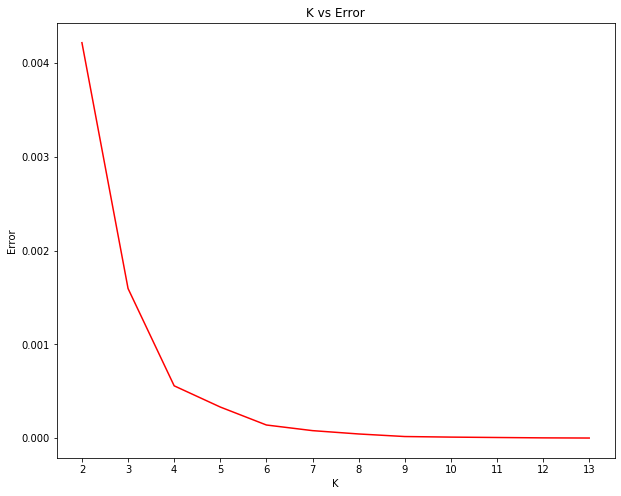

In [40]:
plt.figure(figsize=[10, 8])
sns.lineplot(x=range(2, 14), y=scores, color='r')
plt.title("K vs Error")
plt.xticks(range(2, 14))
plt.xlabel("K")
plt.ylabel("Error")

In [41]:
conda install -c districtdatalabs yellowbrick

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


/Users/yevhentarasov/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


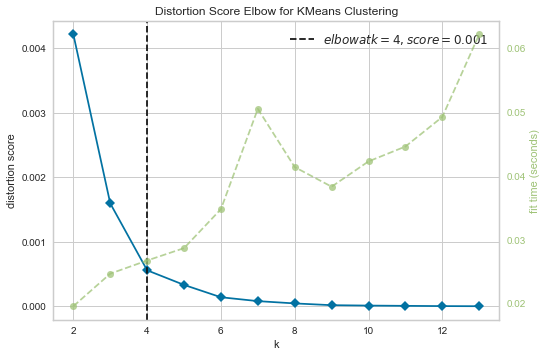

In [42]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,14))

visualizer.fit(X)      
visualizer.show()

Also we check density of clusters using Silhouette Visualizer

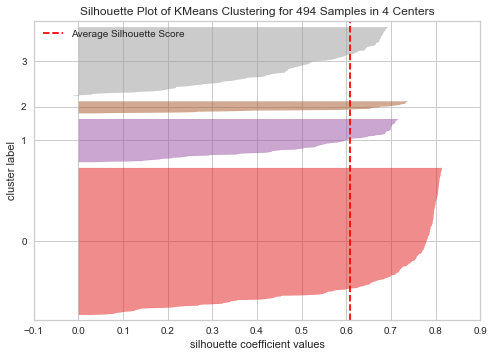

In [43]:
from yellowbrick.datasets import load_nfl
from yellowbrick.cluster import silhouette_visualizer

X, y = load_nfl()
visualizer = silhouette_visualizer(KMeans(4, random_state=8), X)

The optimum K value is 4 so we will divide neighborhoods into 4 clusters

In [44]:
kclusters = 4

toronto_grouped_clustering = ita.drop('Neighborhood', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 3, 0, 0], dtype=int32)

In [45]:
toronto_merged = ita.copy()

toronto_merged["Cluster Labels"] = kmeans.labels_

In [46]:
toronto_merged.head()

Neighborhood  Mexican Restaurant  \
0                                        Agincourt                 0.0   
1                           Alderwood, Long Branch                 0.0   
2  Bathurst Manor, Wilson Heights, Downsview North                 0.0   
3                                  Bayview Village                 0.0   
4                Bedford Park, Lawrence Manor East                 0.0   

   Cluster Labels  
0               0  
1               0  
2               0  
3               0  
4               0

In [47]:
toronto_merged = toronto_merged.join(toronto_venues.set_index("Neighborhood"), on="Neighborhood")

print(toronto_merged.shape)
toronto_merged.head()

(4907, 9)


Neighborhood  Mexican Restaurant  Cluster Labels  Neighborhood Latitude  \
0    Agincourt                 0.0               0                43.7942   
0    Agincourt                 0.0               0                43.7942   
0    Agincourt                 0.0               0                43.7942   
0    Agincourt                 0.0               0                43.7942   
0    Agincourt                 0.0               0                43.7942   

   Neighborhood Longitude                        Venue  Venue Latitude  \
0              -79.262029                 The Roti Hut       43.787277   
0              -79.262029  Panagio's Breakfast & Lunch       43.792370   
0              -79.262029                  Mona's Roti       43.791613   
0              -79.262029     Babu Catering & Take Out       43.791721   
0              -79.262029    Bestco Food Market 鴻華超級市場       43.796514   

   Venue Longitude         Venue Category  
0       -79.258724   Caribbean Restaurant  
0       -79.260203         Breakfast Spot  
0       -79.251015   Caribbean Restaurant  
0       -79.251132  Sri Lankan Restaurant  
0       -79.270790            Supermarket

In [48]:
print(toronto_merged.shape)
toronto_merged.sort_values(["Cluster Labels"], inplace=True, ascending=False)
toronto_merged

(4907, 9)


Neighborhood  Mexican Restaurant  Cluster Labels  \
80                     The Beaches            0.013158               3   
80                     The Beaches            0.013158               3   
80                     The Beaches            0.013158               3   
80                     The Beaches            0.013158               3   
80                     The Beaches            0.013158               3   
..                             ...                 ...             ...   
41  India Bazaar, The Beaches West            0.000000               0   
41  India Bazaar, The Beaches West            0.000000               0   
41  India Bazaar, The Beaches West            0.000000               0   
41  India Bazaar, The Beaches West            0.000000               0   
97        York Mills, Silver Hills            0.000000               0   

    Neighborhood Latitude  Neighborhood Longitude                 Venue  \
80              43.676357              -79.293031        Juice and Java   
80              43.676357              -79.293031       Castro's Lounge   
80              43.676357              -79.293031      I'm On The Beach   
80              43.676357              -79.293031          Beacher Cafe   
80              43.676357              -79.293031                  Xola   
..                    ...                     ...                   ...   
41              43.668999              -79.315572             Starbucks   
41              43.668999              -79.315572       Buds Coffee Bar   
41              43.668999              -79.315572  Ashbridge's Bay Park   
41              43.668999              -79.315572              Pet Valu   
97              43.757490              -79.374714             Ames Park   

    Venue Latitude  Venue Longitude      Venue Category  
80       43.671062       -79.295755                Café  
80       43.671104       -79.295107                 Bar  
80       43.670364       -79.284696               Beach  
80       43.671938       -79.291238      Breakfast Spot  
80       43.672603       -79.288080  Mexican Restaurant  
..             ...              ...                 ...  
41       43.668539       -79.307821         Coffee Shop  
41       43.669375       -79.303218         Coffee Shop  
41       43.661822       -79.310424                Park  
41       43.666979       -79.314665           Pet Store  
97       43.751868       -79.365473                Park  

[4907 rows x 9 columns]

In [49]:
toronto_merged['Venue Category'].value_counts()['Mexican Restaurant']

39

And will map it

In [50]:
map_clusters = folium.Map(location=[location.latitude, location.longitude], zoom_start=12,tiles="CartoDB dark_matter")

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Neighborhood Latitude'], toronto_merged['Neighborhood Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color = rainbow[int(cluster)-1],
        fill_opacity=0.3).add_to(map_clusters)
       
map_clusters

In [75]:
ita['Cluster Labels'] = kmeans.labels_
ita.head()

/Users/yevhentarasov/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Neighborhood  Mexican Restaurant  \
0                                        Agincourt                 0.0   
1                           Alderwood, Long Branch                 0.0   
2  Bathurst Manor, Wilson Heights, Downsview North                 0.0   
3                                  Bayview Village                 0.0   
4                Bedford Park, Lawrence Manor East                 0.0   

   Cluster Labels  
0               0  
1               0  
2               0  
3               0  
4               0

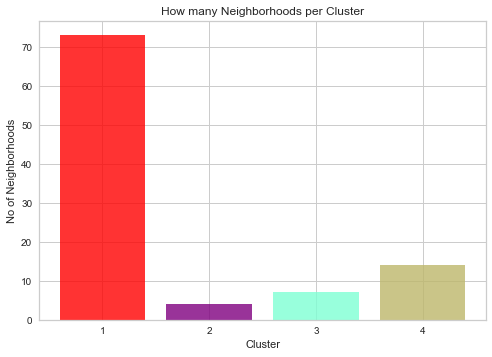

In [76]:
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
performance = ita['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('No of Neighborhoods')
plt.xlabel('Cluster')
plt.title('How many Neighborhoods per Cluster')

plt.show()

In [77]:
ita['Cluster Labels'].value_counts()

0    73
3    14
2     7
1     4
Name: Cluster Labels, dtype: int64

### Now let's explore clusters one by one

1st cluster

In [78]:
df_new = df[['Borough', 'Neighborhood']]
df_new.head()

Borough                            Neighborhood
0  Scarborough                          Malvern, Rouge
1  Scarborough  Rouge Hill, Port Union, Highland Creek
2  Scarborough       Guildwood, Morningside, West Hill
3  Scarborough                                  Woburn
4  Scarborough                               Cedarbrae

In [79]:
cluster1 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0]
df_cluster1 = pd.merge(df_new, cluster1, on='Neighborhood')
df_cluster1

Borough                                       Neighborhood  \
0     Scarborough                                     Malvern, Rouge   
1     Scarborough                                     Malvern, Rouge   
2     Scarborough                                     Malvern, Rouge   
3     Scarborough                                     Malvern, Rouge   
4     Scarborough                                     Malvern, Rouge   
...           ...                                                ...   
3320    Etobicoke  South Steeles, Silverstone, Humbergate, Jamest...   
3321    Etobicoke                Northwest, West Humber - Clairville   
3322    Etobicoke                Northwest, West Humber - Clairville   
3323    Etobicoke                Northwest, West Humber - Clairville   
3324    Etobicoke                Northwest, West Humber - Clairville   

      Mexican Restaurant  Cluster Labels  Neighborhood Latitude  \
0                    0.0               0              43.806686   
1                    0.0               0              43.806686   
2                    0.0               0              43.806686   
3                    0.0               0              43.806686   
4                    0.0               0              43.806686   
...                  ...             ...                    ...   
3320                 0.0               0              43.739416   
3321                 0.0               0              43.706748   
3322                 0.0               0              43.706748   
3323                 0.0               0              43.706748   
3324                 0.0               0              43.706748   

      Neighborhood Longitude                                           Venue  \
0                 -79.194353                                      Lee Valley   
1                 -79.194353                              Tim Hortons / Esso   
2                 -79.194353                     Rouge Park - Woodland Trail   
3                 -79.194353                                         Mr Jerk   
4                 -79.194353                               Upper Rouge Trail   
...                      ...                                             ...   
3320              -79.588437                                   Panorama Park   
3321              -79.594054                                     Tim Hortons   
3322              -79.594054                              Economy Rent A Car   
3323              -79.594054                         Woodbine Hotel & Suites   
3324              -79.594054  Toronto Pearson International Airport Pet Park   

      Venue Latitude  Venue Longitude       Venue Category  
0          43.803161       -79.199681           Hobby Shop  
1          43.801863       -79.199296          Coffee Shop  
2          43.801782       -79.200427                Trail  
3          43.801262       -79.199758   African Restaurant  
4          43.809988       -79.186147                Trail  
...              ...              ...                  ...  
3320       43.747021       -79.583497                 Park  
3321       43.714657       -79.593716          Coffee Shop  
3322       43.708471       -79.589943  Rental Car Location  
3323       43.712624       -79.592664                Hotel  
3324       43.704901       -79.604441              Dog Run  

[3325 rows x 10 columns]

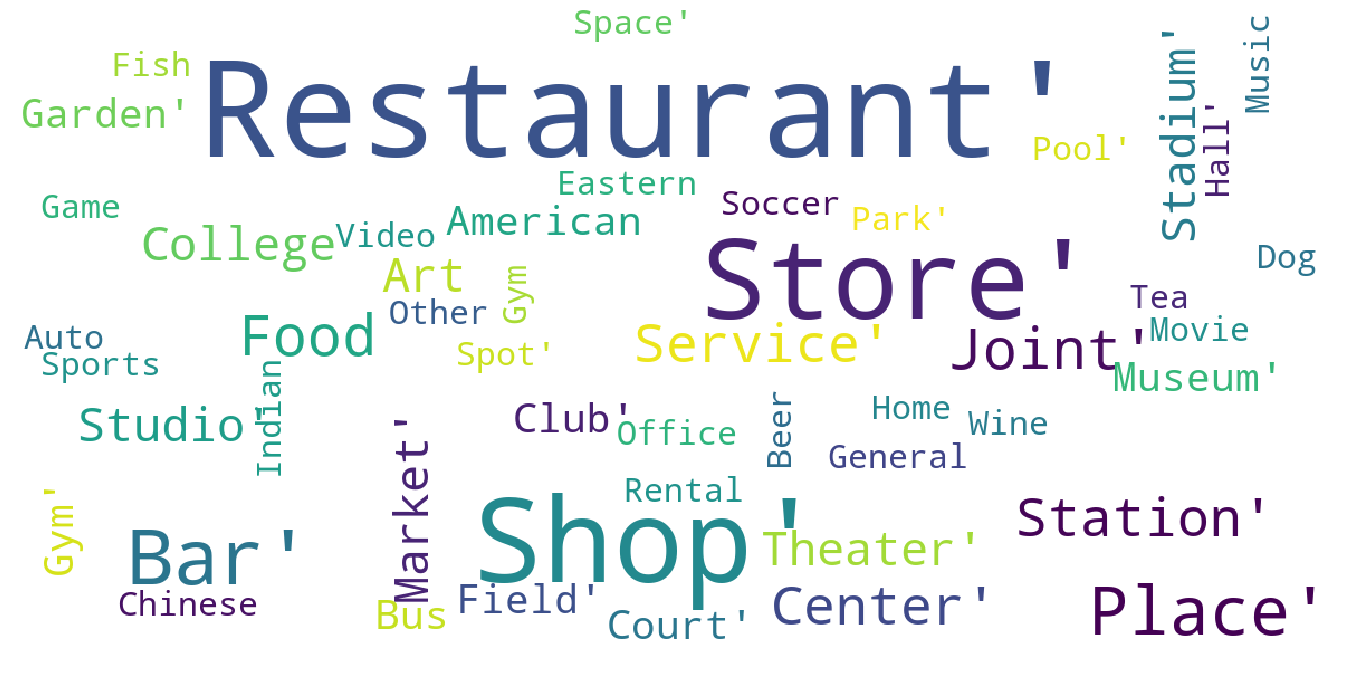

In [80]:
show_wordcloud_small(df_cluster1['Venue Category'].unique())

2nd cluster

In [81]:
cluster2 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 1]
df_cluster2 = pd.merge(df_new, cluster2, on='Neighborhood')
df_cluster2

Borough                                       Neighborhood  \
0   Central Toronto                  North Toronto West, Lawrence Park   
1   Central Toronto                  North Toronto West, Lawrence Park   
2   Central Toronto                  North Toronto West, Lawrence Park   
3   Central Toronto                  North Toronto West, Lawrence Park   
4   Central Toronto                  North Toronto West, Lawrence Park   
..              ...                                                ...   
91        Etobicoke  West Deane Park, Princess Gardens, Martin Grov...   
92        Etobicoke  West Deane Park, Princess Gardens, Martin Grov...   
93        Etobicoke  West Deane Park, Princess Gardens, Martin Grov...   
94        Etobicoke  West Deane Park, Princess Gardens, Martin Grov...   
95        Etobicoke  West Deane Park, Princess Gardens, Martin Grov...   

    Mexican Restaurant  Cluster Labels  Neighborhood Latitude  \
0             0.046512               1              43.715383   
1             0.046512               1              43.715383   
2             0.046512               1              43.715383   
3             0.046512               1              43.715383   
4             0.046512               1              43.715383   
..                 ...             ...                    ...   
91            0.066667               1              43.650943   
92            0.066667               1              43.650943   
93            0.066667               1              43.650943   
94            0.066667               1              43.650943   
95            0.066667               1              43.650943   

    Neighborhood Longitude                             Venue  Venue Latitude  \
0               -79.405678           Sport Chek Yonge Street       43.712860   
1               -79.405678                      Green Papaya       43.710078   
2               -79.405678         Classico Louie's Pizzeria       43.713316   
3               -79.405678                      Douce France       43.711554   
4               -79.405678  De Mello Palheta Coffee Roasters       43.711791   
..                     ...                               ...             ...   
91              -79.554724                Four Seasons Place       43.647128   
92              -79.554724                    Wedgewood Park       43.645335   
93              -79.554724                  Ravenscrest Park       43.658334   
94              -79.554724                         Joe Fresh       43.643911   
95              -79.554724                    East Mall Park       43.643032   

    Venue Longitude       Venue Category  
0        -79.399611  Sporting Goods Shop  
1        -79.399114      Thai Restaurant  
2        -79.399684          Pizza Place  
3        -79.399394               Bakery  
4        -79.399403          Coffee Shop  
..              ...                  ...  
91       -79.563009                Hotel  
92       -79.548411                 Park  
93       -79.552225                 Park  
94       -79.560126       Clothing Store  
95       -79.557383                 Park  

[96 rows x 10 columns]

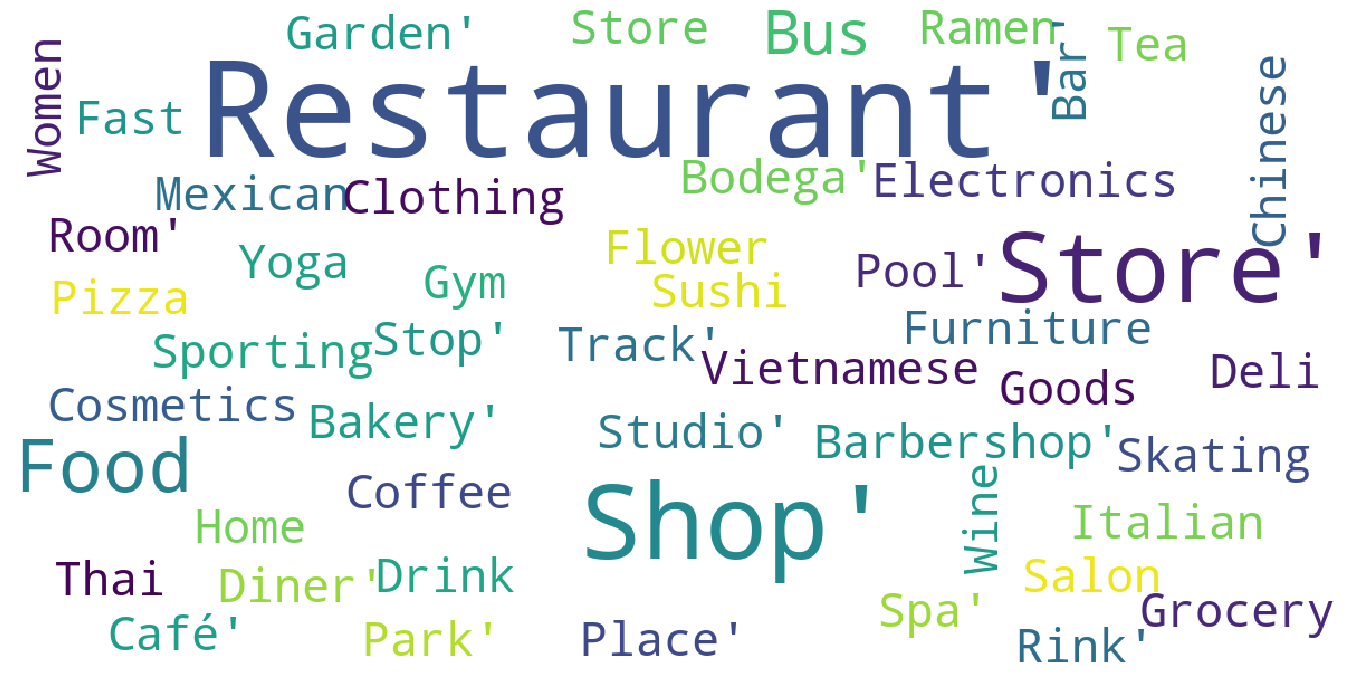

In [82]:
show_wordcloud_small(df_cluster2['Venue Category'].unique())

3rdcluster

In [83]:
cluster3 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 2]
df_cluster3 = pd.merge(df_new, cluster3, on='Neighborhood')
df_cluster3

Borough                           Neighborhood  Mexican Restaurant  \
0    Scarborough        Golden Mile, Clairlea, Oakridge            0.035714   
1    Scarborough        Golden Mile, Clairlea, Oakridge            0.035714   
2    Scarborough        Golden Mile, Clairlea, Oakridge            0.035714   
3    Scarborough        Golden Mile, Clairlea, Oakridge            0.035714   
4    Scarborough        Golden Mile, Clairlea, Oakridge            0.035714   
..           ...                                    ...                 ...   
514  Mississauga  Canada Post Gateway Processing Centre            0.036364   
515  Mississauga  Canada Post Gateway Processing Centre            0.036364   
516  Mississauga  Canada Post Gateway Processing Centre            0.036364   
517  Mississauga  Canada Post Gateway Processing Centre            0.036364   
518  Mississauga  Canada Post Gateway Processing Centre            0.036364   

     Cluster Labels  Neighborhood Latitude  Neighborhood Longitude  \
0                 2              43.711112              -79.284577   
1                 2              43.711112              -79.284577   
2                 2              43.711112              -79.284577   
3                 2              43.711112              -79.284577   
4                 2              43.711112              -79.284577   
..              ...                    ...                     ...   
514               2              43.636966              -79.615819   
515               2              43.636966              -79.615819   
516               2              43.636966              -79.615819   
517               2              43.636966              -79.615819   
518               2              43.636966              -79.615819   

                        Venue  Venue Latitude  Venue Longitude  \
0          Jim McPherson Park       43.712555       -79.296397   
1         Warden Woods Ravine       43.702785       -79.281186   
2      Lucky Lotto Conveniece       43.708795       -79.295665   
3            Sullivan Studios       43.719085       -79.286903   
4           Mackish Irish Pub       43.719932       -79.284328   
..                        ...             ...              ...   
514  Gospel Cafe & Restaurant       43.636510       -79.623512   
515     Quesada Mexican Grill       43.636916       -79.620580   
516             Bamiyan Kabob       43.636510       -79.623555   
517           House of Pepper       43.631939       -79.614494   
518    Chipotle Mexican Grill       43.637412       -79.622280   

                Venue Category  
0                         Park  
1                        Trail  
2            Convenience Store  
3        General Entertainment  
4                          Pub  
..                         ...  
514       Caribbean Restaurant  
515              Burrito Place  
516  Middle Eastern Restaurant  
517           Asian Restaurant  
518         Mexican Restaurant  

[519 rows x 10 columns]

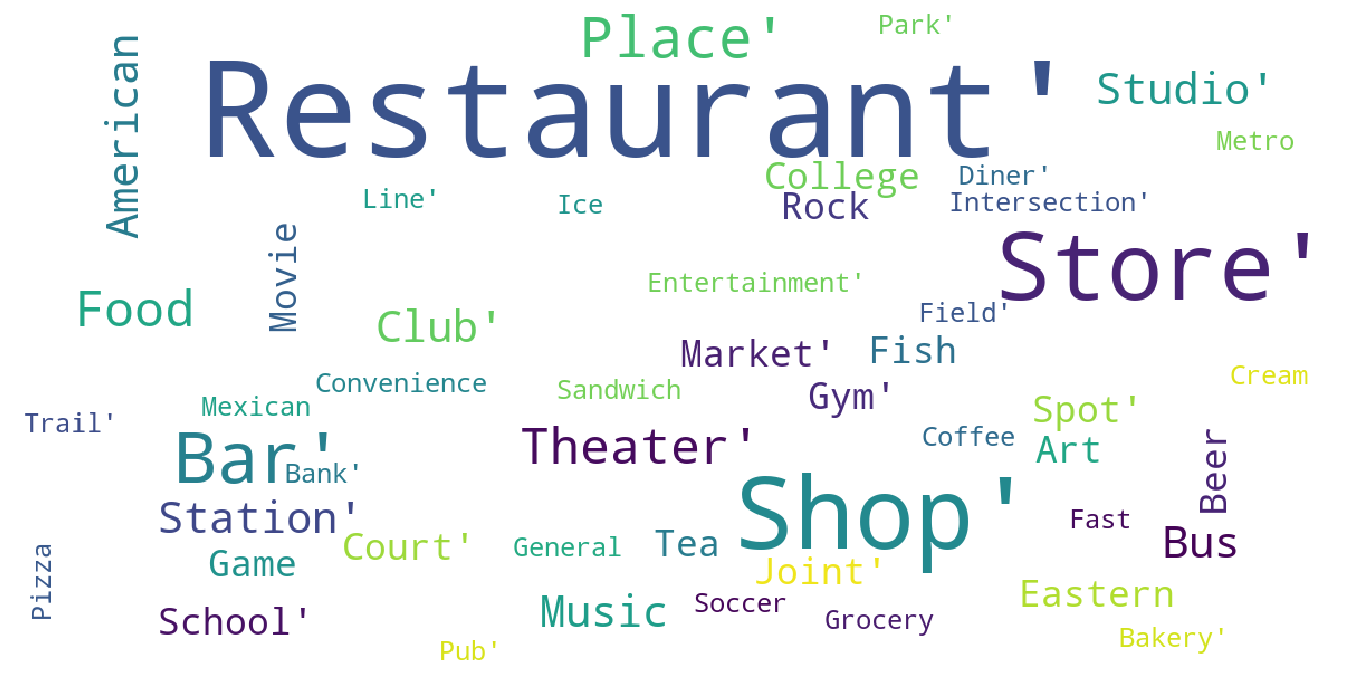

In [84]:
show_wordcloud_small(df_cluster3['Venue Category'].unique())

4th cluster

In [85]:
cluster4 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 3]
df_cluster4 = pd.merge(df_new, cluster4, on='Neighborhood')
df_cluster4

Borough                                       Neighborhood  \
0     East Toronto                                        The Beaches   
1     East Toronto                                        The Beaches   
2     East Toronto                                        The Beaches   
3     East Toronto                                        The Beaches   
4     East Toronto                                        The Beaches   
...            ...                                                ...   
1249     Etobicoke  Mimico NW, The Queensway West, South of Bloor,...   
1250     Etobicoke  Mimico NW, The Queensway West, South of Bloor,...   
1251     Etobicoke  Mimico NW, The Queensway West, South of Bloor,...   
1252     Etobicoke  Mimico NW, The Queensway West, South of Bloor,...   
1253     Etobicoke  Mimico NW, The Queensway West, South of Bloor,...   

      Mexican Restaurant  Cluster Labels  Neighborhood Latitude  \
0               0.013158               3              43.676357   
1               0.013158               3              43.676357   
2               0.013158               3              43.676357   
3               0.013158               3              43.676357   
4               0.013158               3              43.676357   
...                  ...             ...                    ...   
1249            0.018519               3              43.628841   
1250            0.018519               3              43.628841   
1251            0.018519               3              43.628841   
1252            0.018519               3              43.628841   
1253            0.018519               3              43.628841   

      Neighborhood Longitude                    Venue  Venue Latitude  \
0                 -79.293031           Juice and Java       43.671062   
1                 -79.293031          Castro's Lounge       43.671104   
2                 -79.293031         I'm On The Beach       43.670364   
3                 -79.293031             Beacher Cafe       43.671938   
4                 -79.293031                     Xola       43.672603   
...                      ...                      ...             ...   
1249              -79.520999      Dimpflmeier Factory       43.633773   
1250              -79.520999             Burrito Boyz       43.621791   
1251              -79.520999  Fat Bastard Burrito Co.       43.622099   
1252              -79.520999                Dollarama       43.629883   
1253              -79.520999               Wingporium       43.630275   

      Venue Longitude      Venue Category  
0          -79.295755                Café  
1          -79.295107                 Bar  
2          -79.284696               Beach  
3          -79.291238      Breakfast Spot  
4          -79.288080  Mexican Restaurant  
...               ...                 ...  
1249       -79.529895              Bakery  
1250       -79.522601       Burrito Place  
1251       -79.521880       Burrito Place  
1252       -79.518627      Discount Store  
1253       -79.518169         Wings Joint  

[1254 rows x 10 columns]

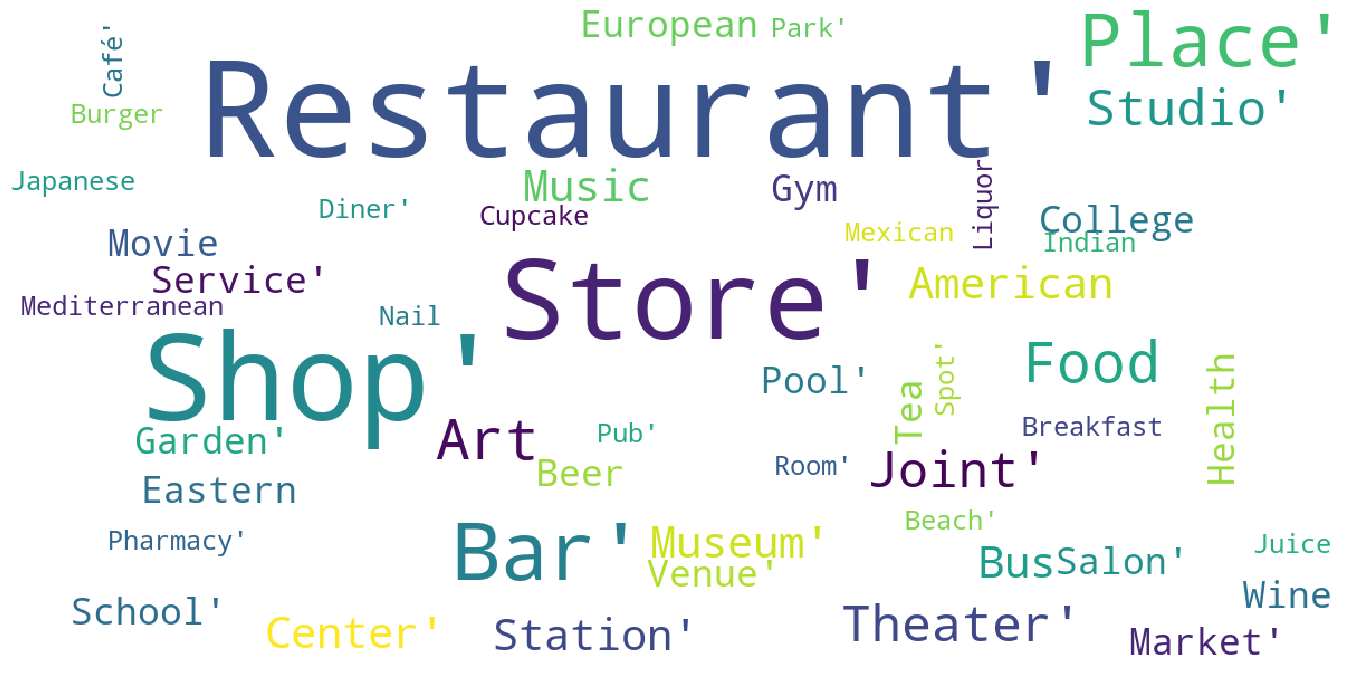

In [86]:
show_wordcloud_small(df_cluster4['Venue Category'].unique())

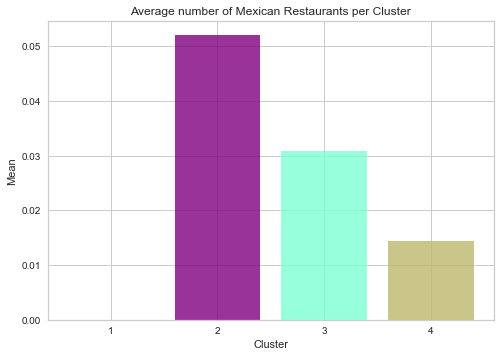

In [87]:
clusters_mean = [df_cluster1['Mexican Restaurant'].mean(),df_cluster2['Mexican Restaurant'].mean(),df_cluster3['Mexican Restaurant'].mean(),
                 df_cluster4['Mexican Restaurant'].mean()]
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
perf = clusters_mean
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('Mean')
plt.xlabel('Cluster')
plt.title('Average number of Mexican Restaurants per Cluster')

plt.show()

In [88]:
clusters_mean

[0.0, 0.05208333333333324, 0.030828516377649183, 0.014354066985645899]